<a href="https://colab.research.google.com/github/kuroro-31/stock-ai-api/blob/master/%E7%B1%B3%E5%9B%BD%E6%A0%AA_%E6%9C%88%E4%BA%88%E6%B8%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
%matplotlib inline

In [ ]:
# META
# GOOG
s_target = 'GOOG'
df = pdr.get_data_yahoo(s_target, start='2010-01-01', end=datetime.now())
# df.head()

[*********************100%***********************]  1 of 1 completed


In [ ]:
## Moving averages
data = df.filter(['Close'])
data['MA10'] = data['Close'].rolling(10).mean()
data['MA20'] = data['Close'].rolling(20).mean()
data['MA50'] = data['Close'].rolling(50).mean()

In [ ]:
# Combine the moving averages with the original dataset
data = pd.concat([data[['Close', 'MA10', 'MA20', 'MA50']]], axis=1)
dataset = data.values

In [ ]:
# データを0〜1の範囲に正規化
dataset = data.values
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

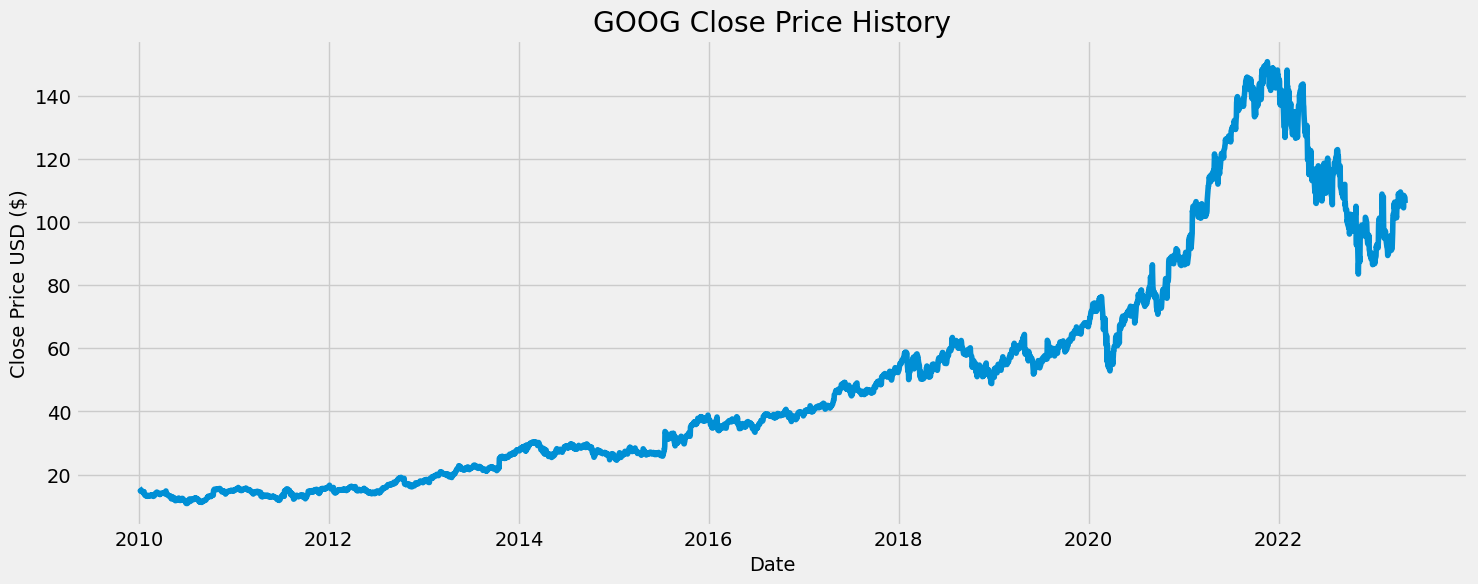

In [ ]:
plt.figure(figsize=(16,6))
plt.title(s_target + ' Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price USD ($)', fontsize=14)
plt.show()

In [ ]:
ma_day = [10, 20, 50]
for ma in ma_day:
    column_name = f"MA for {ma} days"
    df[column_name] = df['Adj Close'].rolling(ma).mean()

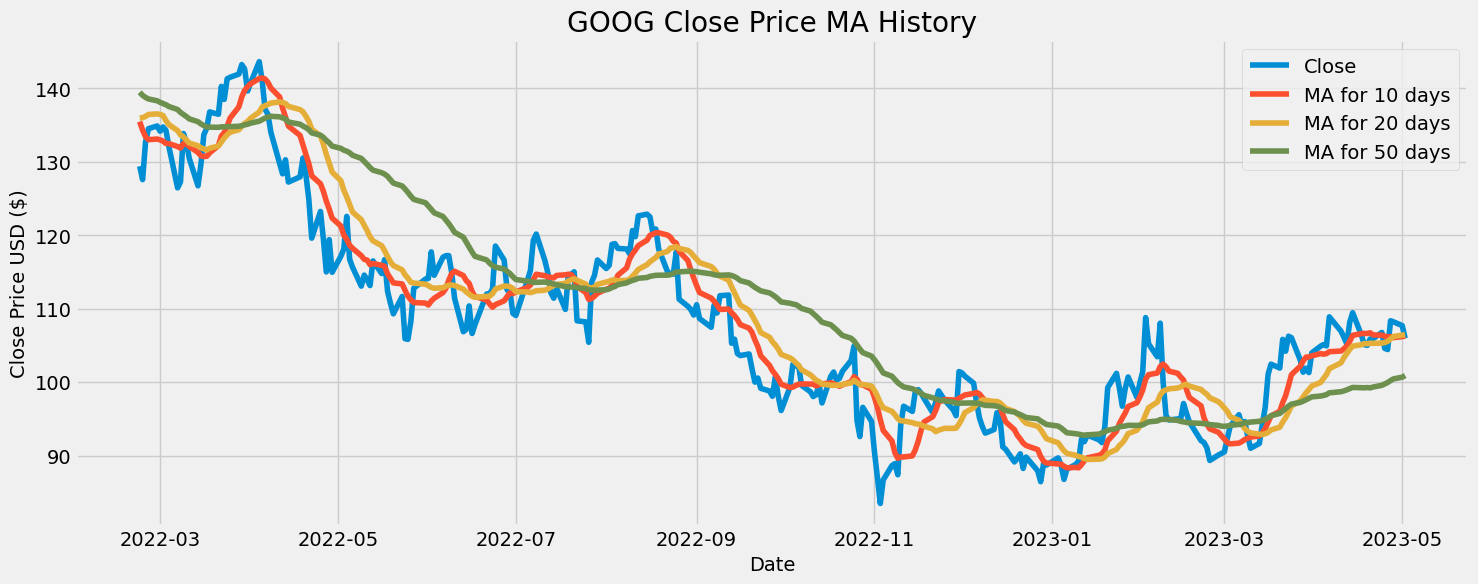

In [ ]:
plt.figure(figsize=(16,6))
plt.title(s_target + ' Close Price MA History')
plt.plot(df['Close'][-300:])
plt.plot(df['MA for 10 days'][-300:])
plt.plot(df['MA for 20 days'][-300:])
plt.plot(df['MA for 50 days'][-300:])
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price USD ($)', fontsize=14)
plt.legend(['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days'], loc='upper right')
plt.show()

In [ ]:
data = df.filter(['Close'])
dataset = data.values
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [ ]:
training_data_len = int(np.ceil( len(dataset) * .9 ))
window_size = 60
train_data = scaled_data[0:int(training_data_len), :]

In [ ]:
# どれくらいの期間をもとに予測するか
window_size = 60

train_data = scaled_data[0:int(training_data_len), :]

# train_dataをx_trainとy_trainに分ける
x_train, y_train = [], []
for i in range(window_size, len(train_data)):
    x_train.append(train_data[i-window_size:i, 0])
    y_train.append(train_data[i, 0])

# numpy arrayに変換
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [ ]:
def create_model(dropout_rate, num_layers, num_units):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=num_units, return_sequences=True, input_shape=(x_train.shape[1], 1))))
    model.add(Dropout(dropout_rate))
    for _ in range(num_layers - 1):
        model.add(Bidirectional(LSTM(units=num_units, return_sequences=True)))
        model.add(Dropout(dropout_rate))
    model.add(Bidirectional(LSTM(units=num_units)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1))
    return model

def train_and_evaluate(x_train, y_train, x_test, y_test, dropout_rate, num_layers, num_units):
    model = create_model(dropout_rate, num_layers, num_units)
    model.compile(optimizer='adam', loss='mean_squared_error')
    early_stop = EarlyStopping(monitor='val_loss', patience=10)
    history = model.fit(x_train, y_train, batch_size=32, epochs=200, validation_split=0.1, callbacks=[early_stop])

    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))

    return model, rmse

In [ ]:
# Optimize dropout rate, number of layers, and number of units
best_dropout_rate = None
best_num_layers = None
best_num_units = None
best_rmse = float('inf')
for rate in np.arange(0.1, 0.6, 0.1):
    for num_layers in range(1, 5):
        for num_units in range(50, 150, 25):
            test_data = scaled_data[training_data_len - window_size: , :]
            x_test = []
            y_test = dataset[training_data_len:, :]
            for i in range(window_size, len(test_data)):
                x_test.append(test_data[i-window_size:i, 0])
            x_test = np.array(x_test)
            x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

            model, rmse = train_and_evaluate(x_train, y_train, x_test, y_test, dropout_rate=rate, num_layers=num_layers, num_units=num_units)

            if rmse < best_rmse:
                best_rmse = rmse
                best_dropout_rate = rate
                best_num_layers = num_layers
                best_num_units = num_units

In [ ]:
dropout_rate = best_dropout_rate
num_layers = best_num_layers
num_units = best_num_units

# Train the model with the optimized hyperparameters and calculate RMSE
model, rmse = train_and_evaluate(x_train, y_train, x_test, y_test, dropout_rate=dropout_rate, num_layers=num_layers, num_units=num_units)

# Train the model again with the optimized hyperparameters and save the best model
model = create_model(dropout_rate, num_layers, num_units)
model.compile(optimizer='adam', loss='mean_squared_error')
early_stop = EarlyStopping(monitor='val_loss', patience=10)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
history = model.fit(x_train, y_train, batch_size=32, epochs=200, validation_split=0.1, callbacks=[early_stop, checkpoint]) 

model.load_weights('best_model.h5')
model.summary()

train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

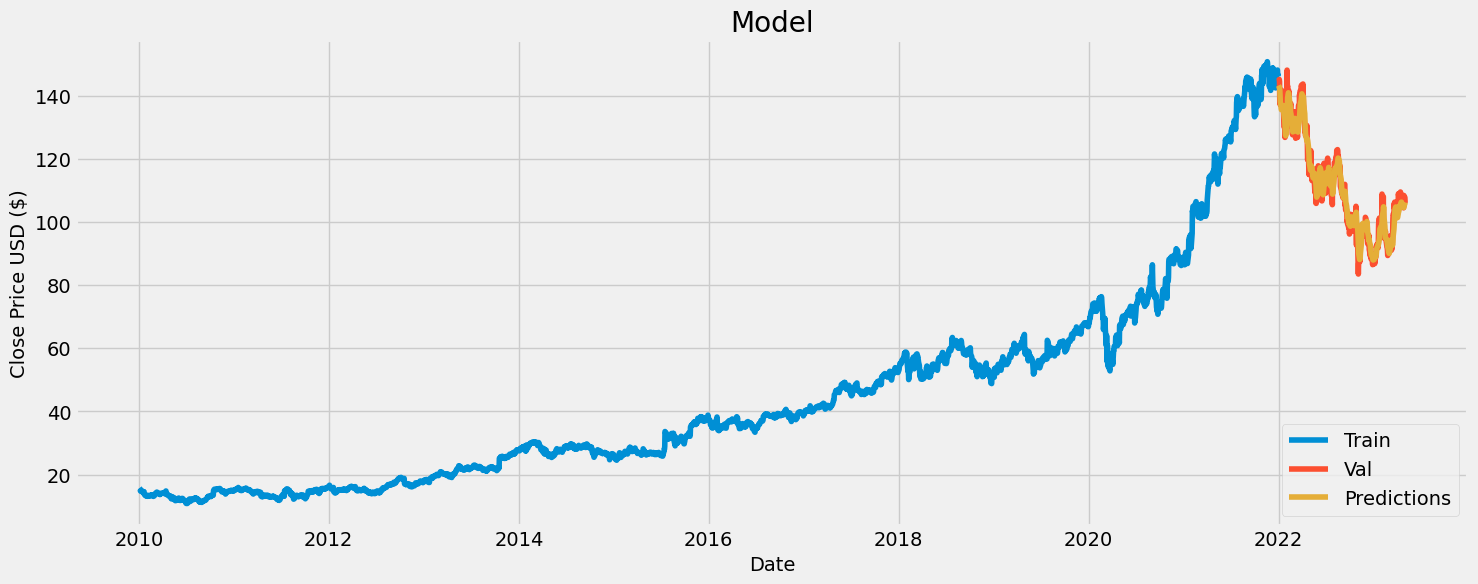

In [138]:
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price USD ($)', fontsize=14)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [136]:
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print(rmse)

r2s = r2_score(y_test, predictions)
print(r2s)
r2s_percentage = r2s * 100
print(f"整合率: {r2s_percentage:.2f}%")

3.5252352588561493
0.9510456629667701
整合率: 95.10%
